In [1]:
import numpy as np
import gmsh
from joblib import Parallel, delayed

from GmshBoundaries import *
from SamplingPatterns import semiCircle
from RayleighCavitySolverRAD import *
from Mesh import Chain

from Plots import *
%matplotlib inline


In [2]:
class ConicalSpeaker(object):
    def __init__(self, coneRadius, coneAngle, capRadius, capHeight, maxElementSize = 0.01):
        self.coneRadius = coneRadius
        self.coneAngle  = coneAngle * np.pi / 180.0
        self.capRadius  = capRadius
        self.capHeight  = capHeight
        self.maxElementSize = maxElementSize
        self.aVertex = None
        self.aSegment = None
        self.nOpenElements = -1
        self.oGeometry = None
        
    def cavityDepth(self):
        return (self.coneRadius - self.capRadius) * np.tan(self.coneAngle)
    
    def capSphereRadius(self):
        return (self.capRadius**2 + self.capHeight**2) / (2.0 * self.capHeight)
    
    def coneEdge(self):
        return [0.0, self.coneRadius, 0.0]
    
    def capEdge(self):
        return [0.0, self.capRadius, -self.cavityDepth()]
    
    def capCenter(self):
        return [0.0, 0.0, self.capHeight - self.cavityDepth()]
    
    def capSphereCenter(self):
        result = self.capCenter()
        result[2] = result[2] - self.capSphereRadius()
        return result
    
    def chain(self, maxElementSize = None):
        """Get a polygonal chain representing the speaker membrane."""
        # check if cached polygonal chain is still good
        if not (maxElementSize is None or maxElementSize == self.maxElementSize):
            self.maxElementSize = maxElementSize
            self.aVertex  = None
            self.aSegment = None
            self.nOpenElements = -1
        if self.aVertex is None or self.aSegment is None or self.nOpenElements == -1:
            gmsh.initialize()
            gmsh.option.setNumber("General.Terminal", 1)
            gmsh.model.add("Cone Speaker")
            gmsh.model.geo.addPoint(0.0, 0.0, 0.0,           self.maxElementSize, 1)
            gmsh.model.geo.addPoint(*self.coneEdge(),        self.maxElementSize, 2)
            gmsh.model.geo.addPoint(*self.capEdge(),         self.maxElementSize, 3)
            gmsh.model.geo.addPoint(*self.capSphereCenter(), self.maxElementSize, 4)
            gmsh.model.geo.addPoint(*self.capCenter(),       self.maxElementSize, 5)
        
            gmsh.model.geo.addLine(1, 2, 1)
            gmsh.model.addPhysicalGroup(1, [1], 1)
            gmsh.model.setPhysicalName(1, 1, "Interface")
            
            gmsh.model.geo.addLine(2, 3, 2)
            gmsh.model.geo.addCircleArc(3, 4, 5, 3)
        
            gmsh.model.addPhysicalGroup(1, [2, 3], 2)
            gmsh.model.setPhysicalName(1, 2, "Speaker Cone")
            gmsh.model.geo.synchronize()
        
            gmsh.model.mesh.generate(1)
            nodeTags, coord, parametricCoord = gmsh.model.mesh.getNodes(1, -1, True)
            self.aVertex = np.asarray(coord, dtype=np.float32).reshape(len(nodeTags), 3)
            # build reordering dictionary
            nodeTagToIdx = dict()
            for i, t in enumerate(nodeTags):
                nodeTagToIdx[t] = i
            aNodeTags = []
            # extract "open elements" or "Interface" first
            elementTypes, elementTags, nodeTags = gmsh.model.mesh.getElements(1, 1)
            assert len(elementTypes) == 1 and elementTypes[0] == 1 # only line segments
            assert len(elementTags) == 1
            assert len(nodeTags) == 1 and len(nodeTags[0]) == len(elementTags[0]) * 2
            aNodeTags.extend(nodeTags[0]) # extract line segment node tags
            self.nOpenElements = len(elementTags[0])
            
            # extract speaker elements
            elementTypes, elementTags, nodeTags = gmsh.model.mesh.getElements(1, 2)
            assert len(elementTypes) == 1 and elementTypes[0] == 1 # only line segments
            assert len(elementTags) == 1
            assert len(nodeTags) == 1 and len(nodeTags[0]) == len(elementTags[0]) * 2
            aNodeTags.extend(nodeTags[0]) # extract line segment node tags
            
            elementTypes, elementTags, nodeTags = gmsh.model.mesh.getElements(1, 3)
            assert len(elementTypes) == 1 and elementTypes[0] == 1 # only line segments
            assert len(elementTags) == 1
            assert len(nodeTags) == 1 and len(nodeTags[0]) == len(elementTags[0]) * 2
            aNodeTags.extend(nodeTags[0]) # extract line segment node tags
            
            # relabel node tags with index into vertex array
            aTempNodeTags = np.empty(len(aNodeTags), dtype=np.int32)
            for i, t in enumerate(aNodeTags):
                aTempNodeTags[i] = nodeTagToIdx[t]
            self.aSegment = aTempNodeTags.reshape(len(aNodeTags) // 2, 2)
            gmsh.finalize()
            
            self.oGeometry = Chain(self.aVertex.shape[0], self.aSegment.shape[0])
            self.oGeometry.aVertex = self.aVertex[:, 1:3]
            self.oGeometry.aEdge = self.aSegment
            self.oGeometry.namedPartition['interface'] = (0, self.nOpenElements)
            self.oGeometry.namedPartition['cavity'] = (self.nOpenElements, self.aSegment.shape[0])
            
        return self.oGeometry
    
    def plotConeSection(self):
        self.chain() # make sure polygonal chain is available
        aX = np.empty(self.aSegment.shape[0] + 1, dtype=np.float32)
        aY = np.empty(self.aSegment.shape[0] + 1, dtype=np.float32)
        aX[0] = self.aVertex[self.aSegment[0, 0], 0]
        aY[0] = self.aVertex[self.aSegment[0, 0], 1]
        for i in range(self.aSegment.shape[0]):
            aX[i+1] = self.aVertex[self.aSegment[i, 1], 2]
            aY[i+1] = self.aVertex[self.aSegment[i, 1], 1]
    
        fig, ax = plt.subplots(figsize = (15, 10))
        ax.plot(aX, aY)
        ax.set_aspect('equal', 'datalim')

def magnitude(k, boundaryCondition, aSamples):
    solution = solver.solveBoundary(k, boundaryCondition)
    sampleSolution = solver.solveExterior(solution, aSamples)
    return SoundMagnitude(soundPressure(k, sampleSolution.aPhi))


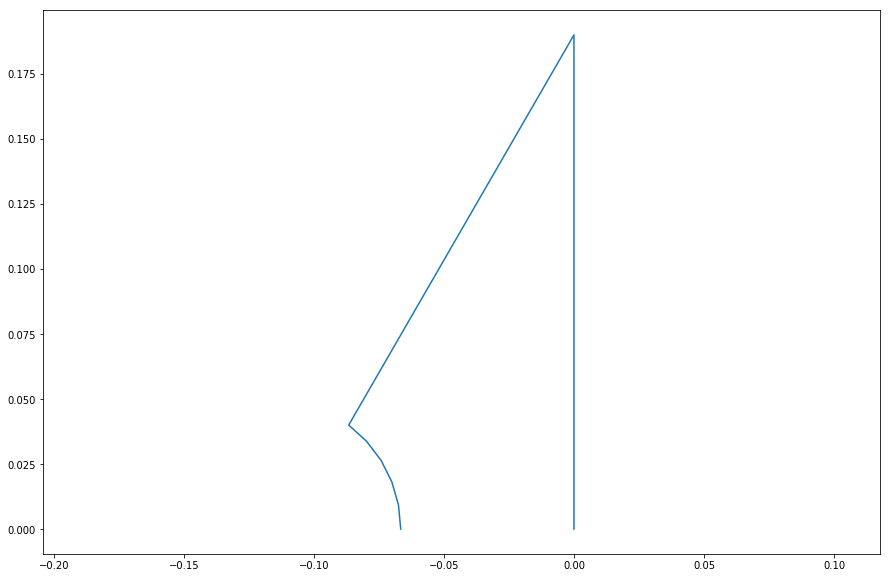

In [3]:
# 15 Inch ~ 38cm -> 19cm cone radius
# 30 degree cone angle
# 8cm dust cap -> 4cm dust cap radius
# 2cm dust cap height
s = ConicalSpeaker(0.19, 30.0, 0.04, 0.02)

s.plotConeSection()


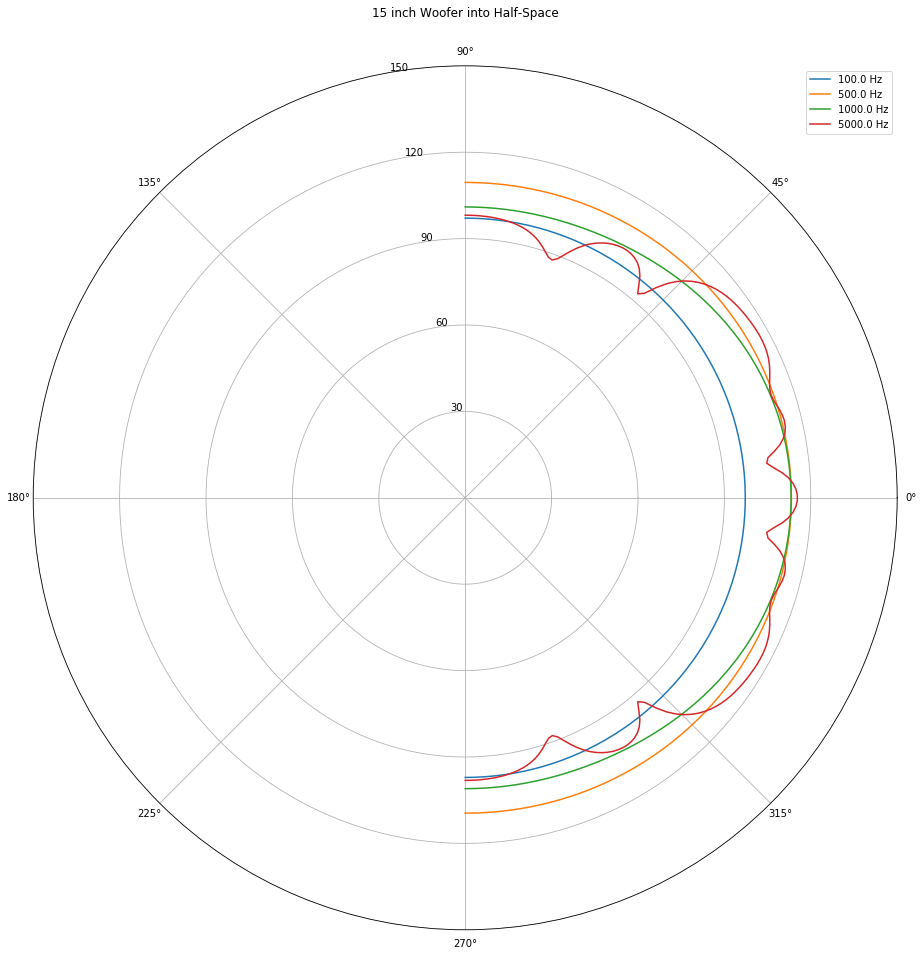

In [6]:
aSamples, _, aAngle = semiCircle(5, 180, "yz")
aSamples = aSamples[:, 1:3] # project down to 2D
aFrequency = np.array([100, 500, 1000, 5000], dtype=np.float32)

oChain = s.chain()
solver = RayleighCavitySolverRAD(s.chain())
nBoundaryElements = solver.numberOfElements()
boundaryCondition = solver.neumannBoundaryCondition()
vVelocity = np.array([1.0, 0.0], dtype=np.float32)
aNormals = solver.cavityNormals()
for i in range(nBoundaryElements):
    boundaryCondition.f[i] = np.dot(vVelocity, aNormals[i, :])

aK = frequencyToWavenumber(aFrequency)
aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundaryCondition, aSamples) for k in aK)
polarPlot("15 inch Woofer into Half-Space", aFrequency, aAngle, aMagnitudes)

CPU times: user 627 ms, sys: 45.3 ms, total: 673 ms
Wall time: 7min 35s


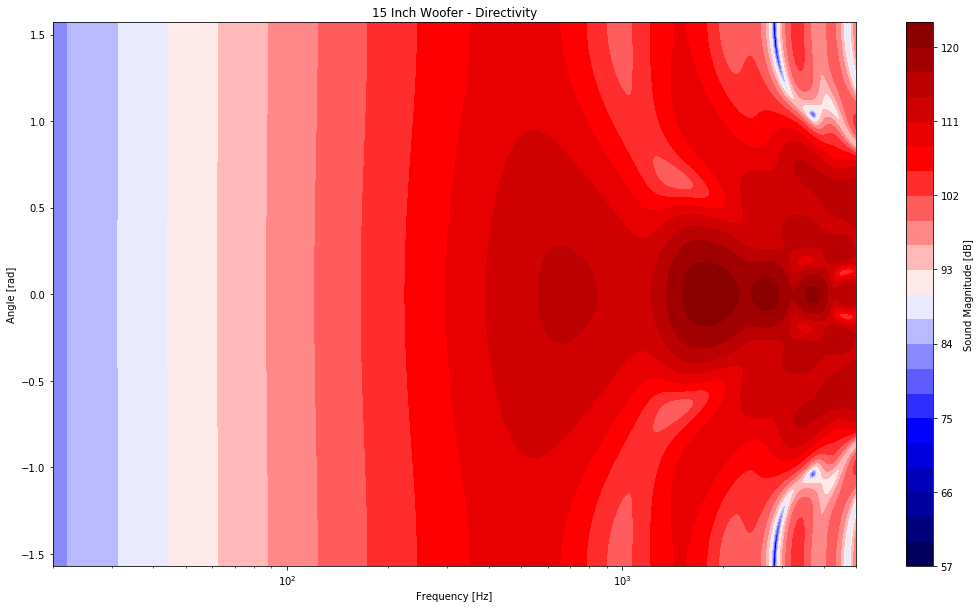

In [5]:
%%time
frequencySamples = 600
aFrequency = np.logspace(np.log10(20), np.log10(5000), frequencySamples)
aWavenumber = frequencyToWavenumber(aFrequency)

aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundaryCondition, aSamples) for k in aWavenumber)
aMagnitudes = np.asarray(aMagnitudes).transpose()

plotPolarMap("15 Inch Woofer - Directivity",
             aFrequency, aAngle, aMagnitudes, 3)